This notebook will run reconstructions on a spectral function with three states, with the form of $\rho$ taken from the HLT paper,
\begin{equation}
    \rho(\omega) = \delta(E - 0.2) + \delta(E - 0.5) + \delta(E - 0.8).
\end{equation}

In [1]:
import os
import sys
from time import time
import numpy as np
import h5py 
import seaborn as sns
import scipy.interpolate as interpolate
import gmpy2 as gmp

from importlib import reload

sys.path.append('/Users/theoares/lqcd/utilities')
import plottools as pt
from formattools import *
pt.set_font()
default_style = styles['notebook']

import numpy as np

sys.path.append('/Users/theoares/lqcd_analysis/lqcd_analysis')
import visualize as plt

sys.path.append('/Users/theoares/lqcd/spectral/recon_tools')
import jax_spline

sys.path.append('/Users/theoares/inverse_problems/inverse_problems')
from inverse_problems import nevanlinna as nv

# I/O functions

In [2]:
def mpc_conj(c):
    conj_c = np.zeros(c.shape, dtype = object)
    for ii, x in enumerate(c):
        conj_c[ii] = gmp.mpc.conjugate(x)
    return conj_c
def mpc_abs(c):
    """Input c should be a list of gmp.mpc objects."""
    abs_c = np.zeros(c.shape, dtype = object)
    for ii, x in enumerate(c):
        abs_c[ii] = gmp.sqrt(gmp.mpc.conjugate(x) * x).real
    return abs_c

In [3]:
def phase(z):
    return np.exp(1j*np.arctan2(z.imag, z.real))

def generate():
    os.system("pwd; python3 gen_single_state_fermions.py /Users/theoares/lqcd/spectral/simulations/data.h5;")

def run(eta = '0.0001', bos_ferm = 'fermion'):
    os.system(f"/Users/theoares/inverse_problems/nevanlinna_disk/Nevanlinna /Users/theoares/lqcd/spectral/simulations/data.h5 /Users/theoares/lqcd/spectral/simulations/recon.h5 {eta} {bos_ferm}")
    
def read_ng(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        # print(ifile['freqs_imag'][:])
        freq_re = np.array(ifile['freqs_real'][:], dtype=float)
        freq_im = np.array(ifile['freqs_imag'][:], dtype=float)
        ng_re = np.array(ifile['ng_real'][:], dtype=float)
        ng_im = np.array(ifile['ng_imag'][:], dtype=float)
        freq = freq_re + 1j*freq_im
        ng = ng_re + 1j*ng_im
    return freq, ng

def read_phis(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        phis_re = np.array(ifile['phi_real'][:], dtype=float)
        phis_im = np.array(ifile['phi_imag'][:], dtype=float)
        phis = phis_re + 1j*phis_im
    return phis

def read_eigs(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        eigs_re = np.array(ifile['eigs_real'][:], dtype=float)
        eigs_im = np.array(ifile['eigs_imag'][:], dtype=float)
        #eigs = eigs_re + 1j*eigs_im
        eigs = eigs_re
    return eigs

def read(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        # Reconstructed frequencies
        start = np.array(ifile['start'][:], dtype=float).item()
        stop = np.array(ifile['stop'][:], dtype=float).item()
        num = np.array(ifile['num'][:], dtype=int).item()
        omega = np.linspace(start, stop, num=num)
        # 
        real = np.array(ifile['recon_real'][:], dtype=float)
        imag = np.array(ifile['recon_imag'][:], dtype=float)
        rho = (real + 1j*imag) / np.pi
    return omega, rho

def read_nev_coeffs(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        print(ifile.keys())
        
        # Reconstructed frequencies
        start = np.array(ifile['start'][:], dtype=float).item()
        stop = np.array(ifile['stop'][:], dtype=float).item()
        num = np.array(ifile['num'][:], dtype=int).item()
        omega = np.linspace(start, stop, num=num)
        tmp = {}
        for key in ['P','Q','R','S']:
            tmp[f'{key}_re'] = np.array(ifile[f'{key}_real'][:], dtype=float)
            tmp[f'{key}_im'] = np.array(ifile[f'{key}_imag'][:], dtype=float)
        
        # DON'T NORMALIZE: destroys the identities we want to keep intact
        # norm = np.max(np.array(list(tmp.values())))
        # for key in tmp:
        #     tmp[key] = tmp[key]/norm
        nev_coeffs = {}
        
        # Rephase a,b,c,d
        for key in ['P','Q','R','S']:
            nev_coeffs[key] = tmp[f'{key}_re'] + 1j*tmp[f'{key}_im']        
        phi = phase(nev_coeffs['P'][0])
        for key in nev_coeffs:
            nev_coeffs[key] = nev_coeffs[key]/phi
    return omega, nev_coeffs

def build_bspline(x, y):
    t, c, k = interpolate.splrep(x, y, s=0, k=4)
    bspline = interpolate.BSpline(t, c, k, extrapolate=False)
    return bspline    

def kernel(x, x0, sigma):
    dx = x - x0
    return np.exp(-0.5*dx**2/sigma**2) / (np.sqrt(2*np.pi) * sigma)

In [4]:
def analytic_ft(z, m, beta):
    prefactor = -1*(1 + np.exp(-m*beta))
    pole1 = 1/(z - m)
    pole2 = 1/(z + m)
    return prefactor * (pole1 + pole2)

# Generate data, run reconstruction

In [5]:
# Generate data
generate()

# Compute spectral function
# eta_str = '1.0'
# eta_str = '0.5'
# eta_str = '0.2'
# eta_str = '0.15'
# eta_str = '0.1'        # default
eta_str = '0.05'         # sigma parameter from HLT paper
# eta_str = '0.01'
# eta_str = '0.0001'
# eta_str = '1e-8'
# eta_str = '1e-12'
# eta_str = '1e-16'
eta = float(eta_str)
run(eta = eta_str)

# Read spectral
omega, rho = read("recon.h5")

/Users/theoares/lqcd/spectral/python_scripts/examples
Writing data to: /Users/theoares/lqcd/spectral/simulations/data.h5
Green's function data written to: /Users/theoares/lqcd/spectral/simulations/data.h5

Running Nevanlinna.
Reading input from: /Users/theoares/lqcd/spectral/simulations/data.h5
Writing output to: /Users/theoares/lqcd/spectral/simulations/recon.h5
Running reconstruction with eta = 0.05
Number of measured Matsubara frequencies: 12
Beta is: 64

Eigenvalues: [2.641186352385848590223832045010615096380275513834967650733713072e-17 + 0i, -4.782870010428744105782177471599252707531896174959811190311455568e-17 + 0i, -5.611127877568988466644302344572142808955518281301521122534401179e-17 + 0i, -1.635306859011341610027054626087557710221653509741183073398845788e-16 + 0i, 2.226264754210959904717413194125650545692533216890944175024526226e-16 + 0i, -2.628483950479090870005494726406904143350410826136689234301996651e-16 + 0i, 7.7268823438313232167975098013365045080973845055949814965104019

## Plot results

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':"Nevanlinna Green's function"}, xlabel='$2\\pi\\omega_n$', ylabel='$C(i\\omega_n)$'>)

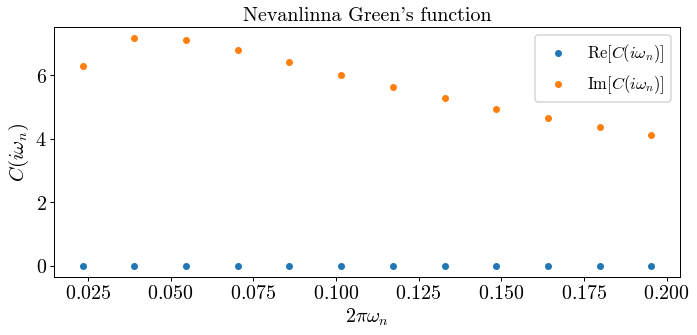

In [6]:
reload(pt)

# NG Green function - on imaginary axis
freq, ng = read_ng("recon.h5")
phis = read_phis("recon.h5")

# Solve the interpolation problem on the disk of w_i = f(z_i)
z_list = nv.moebius(freq)
w_list = nv.moebius(ng)

x = freq.imag / (2*np.pi)
pt.scatter_1d(x, ng, ax_label = [r'$2\pi\omega_n$', r'$C(i\omega_n)$'], mkr = 'o', fn_label = r'C(i\omega_n)', \
              title = 'Nevanlinna Green\'s function', legend = True)

In [7]:
# real part should be identically zero
ng

array([0.+6.30373465j, 0.+7.18027216j, 0.+7.12126601j, 0.+6.79980694j,
       0.+6.41048074j, 0.+6.01446467j, 0.+5.63433123j, 0.+5.2789414j ,
       0.+4.95123915j, 0.+4.65132228j, 0.+4.37789072j, 0.+4.12900259j])

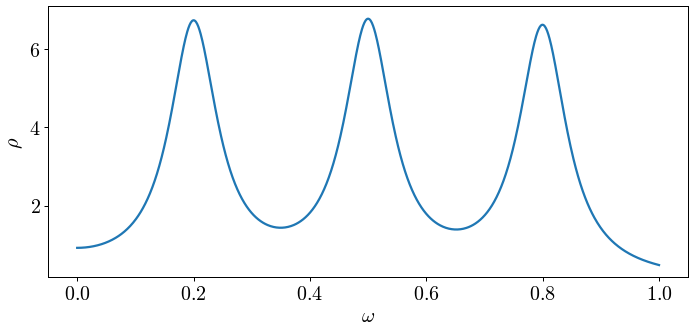

In [8]:
freq, ng = read_ng("recon.h5")
omega, rho = read("recon.h5")

# Reconstructed spectral density
f = build_bspline(omega, rho.imag)
fig, ax = pt.plot_1d_data(omega, rho.imag, ax_label = [r'$\omega$', r'$\rho$'], fn_label = 'Recon')

In [9]:
def delta_eps(z, epsilon = eta):
    return (epsilon / np.pi) / (z**2 + epsilon**2)
poles = [0.2, 0.5, 0.8]
rho_gt = np.zeros(omega.shape, dtype = np.float64)
for pole in poles:
    rho_gt += delta_eps(omega - pole)
    rho_gt += delta_eps(omega + pole)

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:xlabel='$\\omega$', ylabel='$\\rho$'>)

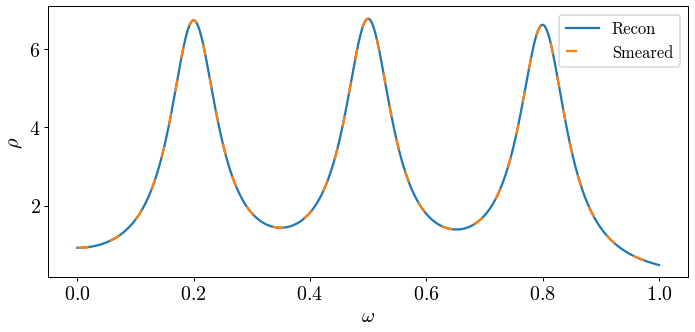

In [10]:
fig, ax = pt.plot_1d_data(omega, rho.imag, ax_label = [r'$\omega$', r'$\rho$'], fn_label = 'Recon', col = pt.pal[0])
pt.plot_1d_data(omega, rho_gt, ax = ax, ax_label = [r'$\omega$', r'$\rho$'], fn_label = 'Smeared', col = pt.pal[1], \
                linestyle = (0, (5, 10)), legend = True)

### Get eigenvalues of Pick matrix

In [11]:
# Note that all the offending eigenvalues have magnitude < machine epsilon (10^{-16})
eigs = read_eigs('recon.h5')
ϵ = 1e-15
# eigs[np.abs(eigs) < ϵ] = 0
eigs

array([ 2.64118635e-17, -4.78287001e-17, -5.61112788e-17, -1.63530686e-16,
        2.22626475e-16, -2.62848395e-16,  7.72688234e-07,  2.00791706e-05,
        1.58083569e-03,  2.76205446e-02,  6.35491927e-01,  6.63833388e+00])

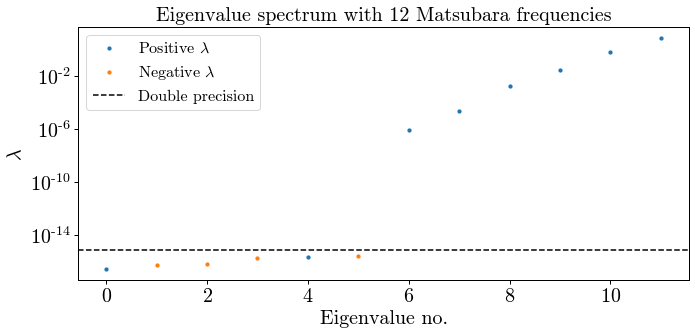

In [12]:
mystyle = default_style.copy()
mystyle['markersize'] = 30
n_eigs = len(eigs)
eig_ids = range(n_eigs)
fig, ax = pt.scatter_1d(eig_ids, eigs, logy = True, fn_label = r'Positive $\lambda$', col=pt.pal[0], style = mystyle)
pt.scatter_1d(eig_ids, -eigs, ax = ax, logy = True, fn_label = r'Negative $\lambda$', col=pt.pal[1], style = mystyle,\
              ax_label = [r'Eigenvalue no.', r'$\lambda$'], \
              title = r'Eigenvalue spectrum with ' + str(n_eigs) + ' Matsubara frequencies',)
machine_eps = 1e-16
machine_prec = np.max(eigs) * machine_eps
pt.add_line(ax, machine_prec, c = 'k', label = 'Double precision', orientation = 'h', linestyle = 'dashed')
ax.legend(fontsize = 16)
fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/tests/eig_spec_' + str(n_eigs) + 'freqs.pdf', \
            bbox_inches = 'tight')

# Study Nevanlinna coefficients analytically

<KeysViewHDF5 ['P_imag', 'P_real', 'Q_imag', 'Q_real', 'R_imag', 'R_real', 'S_imag', 'S_real', 'beta', 'delta_rho_minus_imag', 'delta_rho_minus_real', 'delta_rho_plus_imag', 'delta_rho_plus_real', 'eigs_imag', 'eigs_real', 'eigvecs_0_imag', 'eigvecs_0_real', 'eigvecs_10_imag', 'eigvecs_10_real', 'eigvecs_11_imag', 'eigvecs_11_real', 'eigvecs_1_imag', 'eigvecs_1_real', 'eigvecs_2_imag', 'eigvecs_2_real', 'eigvecs_3_imag', 'eigvecs_3_real', 'eigvecs_4_imag', 'eigvecs_4_real', 'eigvecs_5_imag', 'eigvecs_5_real', 'eigvecs_6_imag', 'eigvecs_6_real', 'eigvecs_7_imag', 'eigvecs_7_real', 'eigvecs_8_imag', 'eigvecs_8_real', 'eigvecs_9_imag', 'eigvecs_9_real', 'eta', 'freqs_imag', 'freqs_real', 'new_ng_imag', 'new_ng_real', 'new_w_imag', 'new_w_real', 'ng_imag', 'ng_real', 'num', 'phi_imag', 'phi_real', 'pick_0_imag', 'pick_0_real', 'pick_10_imag', 'pick_10_real', 'pick_11_imag', 'pick_11_real', 'pick_1_imag', 'pick_1_real', 'pick_2_imag', 'pick_2_real', 'pick_3_imag', 'pick_3_real', 'pick_4_ima

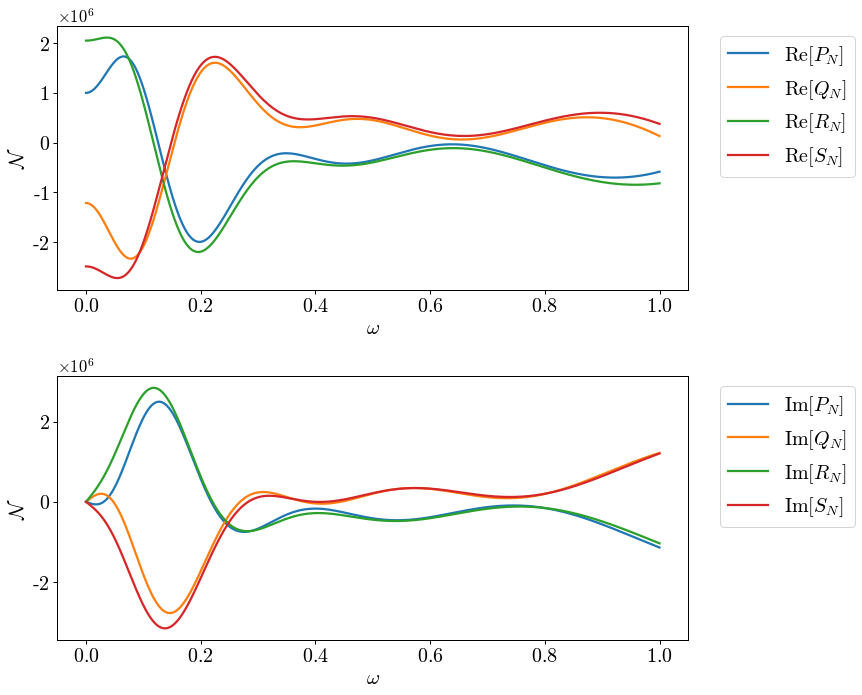

In [13]:
omega, nev_coeffs = read_nev_coeffs("recon.h5")
# nev_cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
nev_cols = pt.pal[:4]

fig, axes = pt.add_subplots(n_rows = 2)
[ax1, ax2] = axes
for ii, key in enumerate(['P','Q','R','S']):
    pt.plot_1d_data(omega, nev_coeffs[key].real, ax = ax1, col = nev_cols[ii], ax_label = [r'$\omega$', \
                      r'$\mathcal{N}$'], fn_label = r'$\mathrm{Re}['+key+'_N]$')
    pt.plot_1d_data(omega, nev_coeffs[key].imag, ax = ax2, col = nev_cols[ii], ax_label = [r'$\omega$', \
                      r'$\mathcal{N}$'], fn_label = r'$\mathrm{Im}['+key+'_N]$')

ax1.legend(bbox_to_anchor=(1.28, 1), loc='upper right', fontsize = default_style['fontsize'])
ax2.legend(bbox_to_anchor=(1.28, 1), loc='upper right', fontsize = default_style['fontsize'])

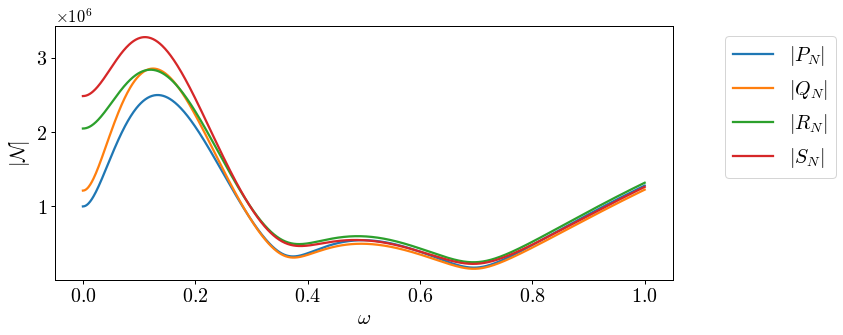

In [14]:
fig, axes = pt.add_subplots()
ax = axes[0]
for ii, key in enumerate(['P','Q','R','S']):
    pt.plot_1d_data(omega, np.abs(nev_coeffs[f"{key}"]), ax = ax, col = nev_cols[ii], \
                      ax_label = [r'$\omega$', r'$|\mathcal{N}|$'], fn_label = r'$|'+key+'_N|$')
ax.legend(bbox_to_anchor=(1.28, 1), loc='upper right', fontsize = default_style['fontsize'])

In [15]:
# Confirm the relation P_N S_N - Q_N R_N = B_N
def B_N(z):
    b = 1.0
    #for iw in freq:
    for hfreq in z_list:
        b *= nv.blashke(z, hfreq)
    return b
# B_N should have zeros at the corresponding frequencies
print([B_N(hfreq) for hfreq in z_list])

[0j, (-0+0j), 0j, 0j, (-0+0j), 0j, 0j, (-0+0j), 0j, 0j, (-0+0j), 0j]


In [16]:
print(freq)      # NOTE THESE ARE STILL MATSUBARA FREQS, DON'T USE THEM
print(z_list)    # MOBIUS TRANSFORM OF MATSUBARA FREQS, USE THESE

[0.+0.14726216j 0.+0.24543693j 0.+0.3436117j  0.+0.44178647j
 0.+0.53996124j 0.+0.63813601j 0.+0.73631078j 0.+0.83448555j
 0.+0.93266032j 0.+1.03083509j 0.+1.12900986j 0.+1.22718463j]
[-0.74328072-0.j -0.60586213-0.j -0.4885253 -0.j -0.38716797-0.j
 -0.29873399-0.j -0.22089985-0.j -0.15186753-0.j -0.09022391-0.j
 -0.034843  -0.j  0.01518345+0.j  0.06059618+0.j  0.1020053 +0.j]


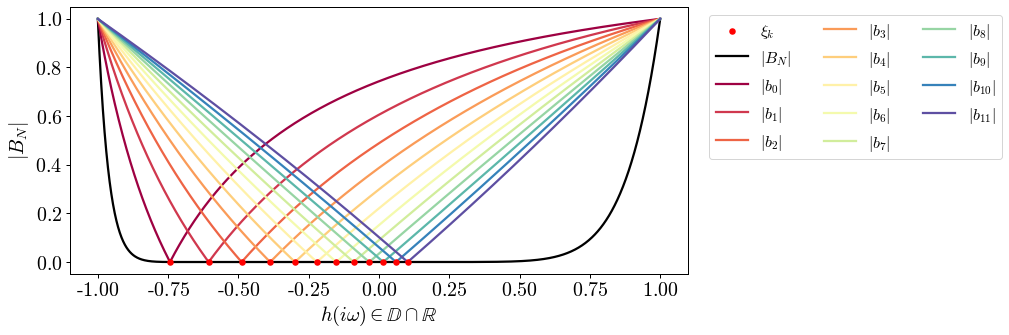

In [17]:
# Plot the Blashke product B_N on the real axis (should have zeros at the given frequencies)
re_axis = np.linspace(-1.0, 1.0, num = 1000)

import matplotlib as mpl
blaschke_cols = mpl.cm.get_cmap('Spectral')(np.linspace(0, 1, len(freq)))

fig, axes = pt.add_subplots()
ax1 = axes[0]

freq_style = default_style.copy()
freq_style['markersize'] = 100
pt.scatter_1d(np.real(z_list), np.zeros(len(freq)), ax = ax1, col = 'r', fn_label = r'$\xi_k$', zorder = 10, style = freq_style)
pt.plot_1d_data(re_axis, np.abs(np.array([B_N(x) for x in re_axis])), ax = ax1, fn_label = r'$|B_N|$', col = 'k')
for ii in range(len(freq)):
    pt.plot_1d_data(re_axis, np.abs(np.array([nv.blashke(x, z_list[ii]) for x in re_axis])), ax = ax1, \
                       fn_label = r'$|b_{' + str(ii) + r'}|$', ax_label=[r'$h(i\omega)\in\mathbb{D}\cap\mathbb{R}$', \
                       r'$|B_N|$'], col = blaschke_cols[ii])

ax1.legend(bbox_to_anchor=(1.52, 1), loc='upper right', ncol=3, fontsize = '16')
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/blashke_real_axis.pdf', bbox_inches = 'tight')

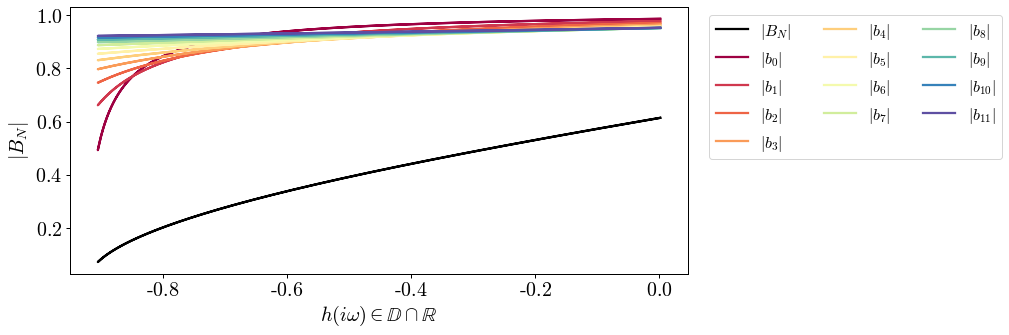

In [18]:
# Plot the Blashke product B_N on the evaluation axis
# ev_axis = nv.moebius(np.linspace(0.0, 0.2, num = 1000) + 1j*1e-10)
# ev_axis = nv.moebius(np.linspace(0.0, 0.2, num = 1000) + 1j*eta)
ev_axis = nv.moebius(np.linspace(-1.0, 1.0, num = 1000) + 1j*eta)

fig, axes = pt.add_subplots()
ax1 = axes[0]

pt.plot_1d_data(np.real(ev_axis), np.abs(np.array([B_N(x) for x in ev_axis])), ax = ax1, fn_label = r'$|B_N|$', col = 'k')
for ii in range(len(freq)):
    pt.plot_1d_data(np.real(ev_axis), np.abs(np.array([nv.blashke(x, z_list[ii]) for x in ev_axis])), ax = ax1, \
                      fn_label = r'$|b_{' + str(ii) + r'}|$', ax_label=[r'$h(i\omega)\in\mathbb{D}\cap\mathbb{R}$', \
                      r'$|B_N|$'], col = blaschke_cols[ii])

ax1.legend(bbox_to_anchor=(1.52, 1), loc='upper right', ncol=3, fontsize = '16')
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/blashke_eval_axis.pdf', bbox_inches = 'tight')

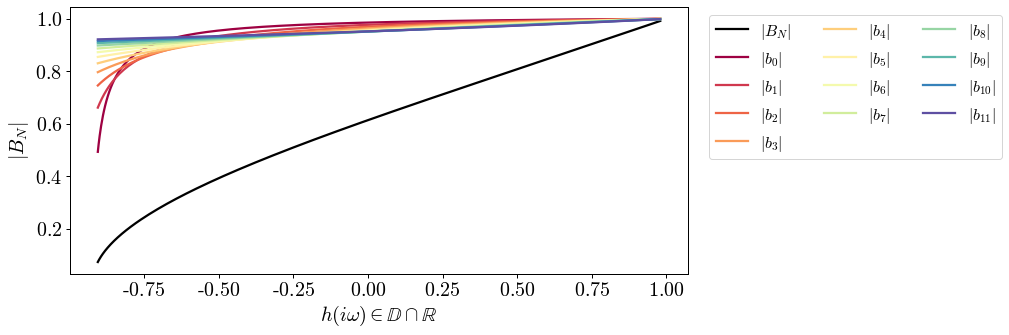

In [19]:
# Plot the Blashke product B_N on the evaluation axis
ev_axis = nv.moebius(np.linspace(0.0, 10.0, num = 1000) + 1j*eta)

fig, axes = pt.add_subplots()
ax1 = axes[0]

pt.plot_1d_data(np.real(ev_axis), np.abs(np.array([B_N(x) for x in ev_axis])), ax = ax1, fn_label = r'$|B_N|$', col = 'k')
for ii in range(len(freq)):
    pt.plot_1d_data(np.real(ev_axis), np.abs(np.array([nv.blashke(x, z_list[ii]) for x in ev_axis])), ax = ax1, \
                      fn_label = r'$|b_{' + str(ii) + r'}|$', ax_label=[r'$h(i\omega)\in\mathbb{D}\cap\mathbb{R}$', \
                      r'$|B_N|$'], col = blaschke_cols[ii])

ax1.legend(bbox_to_anchor=(1.52, 1), loc='upper right', ncol=3, fontsize = '16')
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/blashke_eval_axis_full.pdf', bbox_inches = 'tight')

### Evaluate $P_N S_N - Q_N R_N$ with double precision

In [20]:
# eval_line = nv.moebius(x + 1j*eta)
eval_line = nv.moebius(omega + 1j*eta)
B_N_eval = np.array([B_N(z) for z in eval_line])

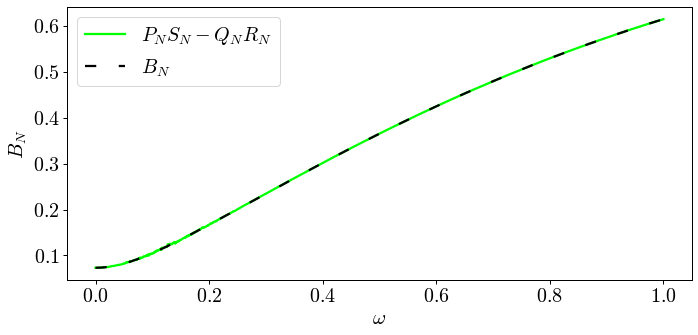

In [21]:
fig, axes = pt.add_subplots()
ax1 = axes[0]
det = nev_coeffs['P'] * nev_coeffs['S'] - nev_coeffs['Q'] * nev_coeffs['R']

pt.plot_1d_data(omega, np.abs(det), ax = ax1, fn_label=r'$P_N S_N - Q_N R_N$', col = 'lime')
pt.plot_1d_data(omega, np.abs(B_N_eval), ax = ax1, fn_label=r'$B_N$', col = 'k', linestyle = (0, (5, 10)))
pt.add_xlabel(ax1, r'$\omega$')
pt.add_ylabel(ax1, r'$B_N$')
ax1.legend(fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/det_identity_double_prec.pdf', bbox_inches = 'tight')

### Evaluate $P_N S_N - R_N Q_N$ at extended precision

TODO: check out how the curves vary as we vary the number of input points

Once you go to a sufficiently large number of Matsubara frequencies, you need extended precision on the Nevanlinna coefficients to reproduce the desired identities. I'm not yet sure how this scales, but it might be a good idea to play with. 

The key here is that even if the input data is double precision and has error bars (i.e. it's imprecise), you **still need to keep extended precision on the Nevanlinna coefficients to reproduce the desired identities**. Even if your input data is not extended precision, the Nevanlinna problem is **still a well-defined mathematical problem**, and satisfies all the identities proved in the paper. However, to see these identities in action, you **must treat the problem with extended precision**. 

In [22]:
# prec = 128
# prec = 1028
# gmp.get_context().allow_complex = True
# gmp.get_context().precision = prec

ONE = gmp.mpc(1, 0)
I = gmp.mpc(0, 1)
h = lambda z : (z - I) / (z + I)
hinv = lambda q : I * (gmp.mpc(1, 0) + q) / (gmp.mpc(1, 0) - q)
eta_mpc = gmp.mpc(eta_str)

def read_nev_coeffs_extended(fname):
    fname = '/Users/theoares/lqcd/spectral/simulations/' + fname
    with h5py.File(fname, 'r') as ifile:
        # Reconstructed frequencies
        start = np.array(ifile['start'][:], dtype=float).item()
        stop = np.array(ifile['stop'][:], dtype=float).item()
        num = np.array(ifile['num'][:], dtype=int).item()
        omega = np.linspace(start, stop, num=num)
        tmp = {}
        for key in ['P','Q','R','S']:
            tmp[f'{key}_re'] = np.array([gmp.mpc(x) for x in ifile[f'{key}_real'][()]], dtype=object)
            tmp[f'{key}_im'] = np.array([gmp.mpc(x) for x in ifile[f'{key}_imag'][()]], dtype=object)
        
        # DON'T NORMALIZE: destroys the identities we want to keep intact
        nev_coeffs = {}
        
        # Rephase a,b,c,d
        for key in ['P','Q','R','S']:
            nev_coeffs[key] = tmp[f'{key}_re'] + gmp.mpc(0, 1) * tmp[f'{key}_im']        
        # phi = phase(nev_coeffs['P'][0])
        # for key in nev_coeffs:
        #     nev_coeffs[key] = nev_coeffs[key]/phi
    return omega, nev_coeffs

omega_ext, nev_coeffs_ext = read_nev_coeffs_extended("recon.h5")

In [23]:
# Confirm the relation P_N S_N - Q_N R_N = B_N
def B_N_ext(z):
    b = ONE
    for hfreq in z_list:
        b *= nv.blashke(z, hfreq)
    return b
eval_line_ext = np.array([nv.moebius(gmp.mpc(xx) + I*eta) for xx in omega], dtype = 'object')
B_N_eval_ext = np.array([B_N_ext(z) for z in eval_line_ext])

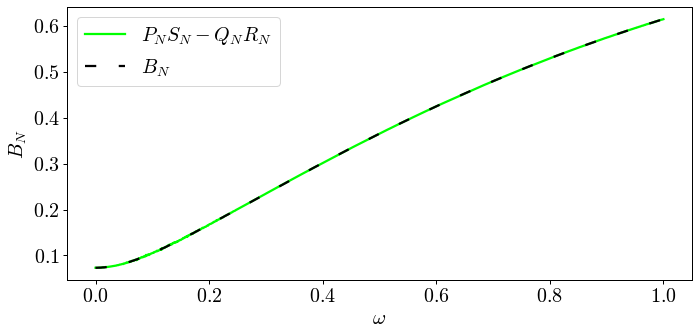

In [24]:
fig, axes = pt.add_subplots()
ax1 = axes[0]
det = np.complex128(nev_coeffs_ext['P'] * nev_coeffs_ext['S'] - nev_coeffs_ext['Q'] * nev_coeffs_ext['R'])

pt.plot_1d_data(omega, np.abs(det), ax = ax1, fn_label=r'$P_N S_N - Q_N R_N$', col = 'lime')
pt.plot_1d_data(omega, np.abs(np.complex128(B_N_eval)), ax = ax1, fn_label=r'$B_N$', col = 'k', linestyle = (0, (5, 10)))
pt.add_xlabel(ax1, r'$\omega$')
pt.add_ylabel(ax1, r'$B_N$')
ax1.legend(fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/det_identity_ext_prec.pdf', bbox_inches = 'tight')

### Make sure I can reconstruct the spectral function with $\theta_{N+1} \equiv 0$

In [25]:
rho_zero_fn_disk = nev_coeffs_ext['Q'] / nev_coeffs_ext['S']
rho_zero_fn = hinv(rho_zero_fn_disk) / gmp.const_pi()

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Recon with $\\theta_{N+1} = 0$'}, xlabel='$\\omega$', ylabel='$\\rho$'>)

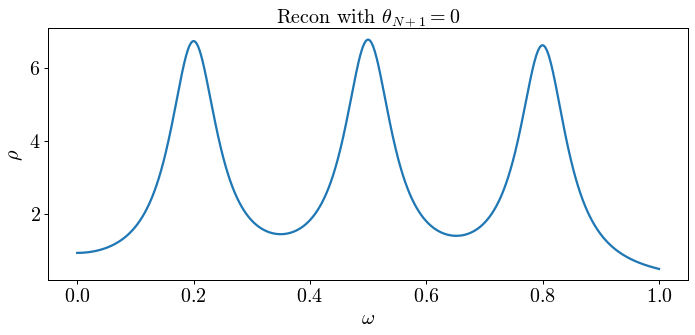

In [26]:
pt.plot_1d_data(omega, np.complex128(rho_zero_fn).imag, ax_label = [r'$\omega$', r'$\rho$'], \
                title = r'Recon with $\theta_{N+1} = 0$')

### Evaluate the center and radius of the solution disk

Analytically, the set of all possible solutions at $\zeta\in\mathbb D$ is 
$$
    \Delta(\zeta) := \{ f(\zeta) : f \text{ is a Nevanlinna interpolant}  \},
$$
and can be proven to be a Euclidean disk of center 
$$
    c_N(\zeta) := \frac{P_N(\zeta) \left( -\frac{R_N}{S_N}(\zeta) \right)^* + Q_N(\zeta)}{R_N(\zeta) \left( -\frac{R_N}{S_N}(\zeta) \right)^* + S_N(\zeta)} = \frac
    {Q_N(\zeta) \bar{S}_N(\zeta) - P_N(\zeta) \bar{R}_N(\zeta)}
    {|S_N(\zeta)|^2 - |R_N(\zeta)|^2}
$$
with radius:
$$
    \rho_N(\zeta) := \frac{|B_N(\zeta)|}{|S_N(\zeta)|^2 - |R_N(\zeta)|^2}.
$$
Note that solutions are in the disk, and need to be mapped back to the complex plane with $h^{-1}$. 

In [27]:
rN = mpc_abs(B_N_eval_ext) / (mpc_abs(nev_coeffs_ext['S'])**2 - mpc_abs(nev_coeffs_ext['R'])**2)
mRoverS_conj = mpc_conj( -nev_coeffs_ext['R'] / nev_coeffs_ext['S'] )
cN = (nev_coeffs_ext['P']*mRoverS_conj+nev_coeffs_ext['Q']) / (nev_coeffs_ext['R']*mRoverS_conj+nev_coeffs_ext['S'])

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Pullback of $c_N$'}, xlabel='$\\omega$', ylabel='$\\mathrm{Im}[h^{-1}\\circ c_N]$'>)

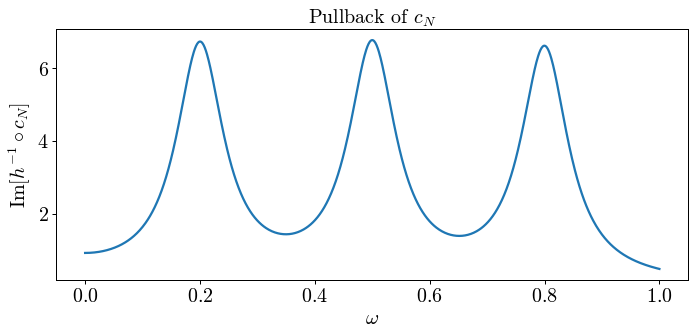

In [28]:
rho_center = hinv(cN) / gmp.const_pi()
pt.plot_1d_data(omega, np.complex128(rho_center).imag, title = r'Pullback of $c_N$', \
                  ax_label = [r'$\omega$', r'$\mathrm{Im}[h^{-1}\circ c_N]$'])

#### Plot the wertevorrat (both in $\mathbb D$ and in $\mathbb C^+$)

In [29]:
# now with error bands
ex_idx = 100
tt = np.linspace(0, 1, num = 1000)
dDelta = np.zeros((len(cN), len(tt)), dtype = object)
dGamma = np.zeros((len(cN), len(tt)), dtype = object)
for ii in range(len(cN)):
    for tidx, t in enumerate(tt):
        dDelta[ii, tidx] = cN[ii] + rN[ii] * gmp.exp(gmp.mpc('2')*gmp.const_pi()*gmp.mpc(0, 1)*gmp.mpc(str(t)))
    dGamma[ii] = hinv(dDelta[ii]) / gmp.const_pi()
dDelta_float = np.complex128(dDelta)
dGamma_float = np.complex128(dGamma)    # \partial\mathcal{D}, the boundary of the wertevorrat in C^+
cN_float = np.complex128(cN)
rN_float = np.float64(rN)

In [30]:
# pi_Gamma = dGamma_float.imag / np.pi
pi_Gamma = dGamma_float.imag
delta_rho_plus = np.max(pi_Gamma, axis = 1)
delta_rho_minus = np.min(pi_Gamma, axis = 1)

Currently the smeared spectral function is lying just outside the wertevorrat: what's going on here?
When the wertevorrat is smaller, it's obviously easier for the smeared $\rho$ to lie outside of it (i.e. you only see this as $\eta$ gets larger and larger) but (**think about and verify this**) the wertevorrat should always contain the ground truth smeared spectral function, no matter how small it is

In [31]:
# %matplotlib notebook

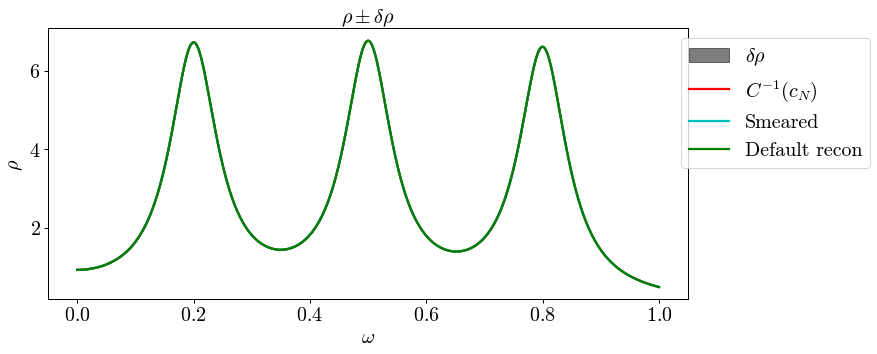

In [32]:
fig, axes = pt.add_subplots()
ax = axes[0]
ax.fill_between(omega, delta_rho_minus, delta_rho_plus, color = 'k', alpha = 0.5, label = r'$\delta\rho$')
pt.plot_1d_data(omega, np.complex128(rho_center).imag, ax = ax, col = 'r', fn_label = r'$C^{-1}(c_N)$')
pt.plot_1d_data(omega, rho_gt, ax = ax, col = 'c', fn_label = 'Smeared')
pt.plot_1d_data(omega, np.complex128(rho_zero_fn).imag, ax = ax, fn_label = r'Default recon', col = 'g')

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$\rho$')
ax.set_title(r'$\rho\pm\delta\rho$', fontsize = default_style['fontsize'])

pt.stylize_axis(ax)
ax.legend(bbox_to_anchor=(1.3, 1), loc='upper right', fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/wertevorrat_smeared_rho.pdf', bbox_inches = 'tight')

In [33]:
print('Default reconstruction (theta_{m+1} = 0) lies inside wertevorrat:')
print(np.all(np.logical_and(delta_rho_minus <= np.complex128(rho_zero_fn).imag, np.complex128(rho_zero_fn).imag <= delta_rho_plus)))

print('Smeared spectral function lies inside wertevorrat:')
print(np.all(np.logical_and(delta_rho_minus <= rho_gt, rho_gt <= delta_rho_plus)))

delta = 1e-12    # Small number to adjust for floating point error
print('Smeared spectral function lies inside wertevorrat, up to precision ' + str(delta) + ':')
print(np.all(np.logical_and(delta_rho_minus - delta <= rho_gt, rho_gt <= delta_rho_plus + delta)))

Default reconstruction (theta_{m+1} = 0) lies inside wertevorrat:
False
Smeared spectral function lies inside wertevorrat:
False
Smeared spectral function lies inside wertevorrat, up to precision 1e-12:
True


## Major TODO
We're seeing here that the smeared spectral function does not lie inside the wertevorrat; it's extremely close, right up to almost floating-point precision, but it's not inside it. We either need to be more careful about the precision, or account for the fact that they can be very very slightly off. Things to check:
<!-- 1. See if there is an analytic solution for the size of the pullback of the wertevorrat, in terms of Mobius transformations. -->
1. Change the `Prec<T>::is_zero` function; currently sets things to zero at precision 1e-10.
2. Make sure all precision is accounted for and everything is correctly implemented; there's likely an error coming from a precision issue somewhere.
3. See if we still have this issue after the eigenvalue cut. If it goes away, then the issue is likely due to the Pick matrix.

In [34]:
# rho_gt - delta_rho_minus
delta_rho_plus - delta_rho_minus

array([1.79634085e-13, 1.79856130e-13, 1.79856130e-13, 1.80300219e-13,
       1.80522264e-13, 1.80633286e-13, 1.80966353e-13, 1.81299420e-13,
       1.81854531e-13, 1.82520665e-13, 1.82964754e-13, 1.83630888e-13,
       1.84297022e-13, 1.85185201e-13, 1.86073379e-13, 1.87072580e-13,
       1.87849736e-13, 1.88959959e-13, 1.89959160e-13, 1.91402449e-13,
       1.92512672e-13, 1.93733918e-13, 1.95288230e-13, 1.96953565e-13,
       1.98507877e-13, 2.00062189e-13, 2.01949568e-13, 2.03614903e-13,
       2.05391260e-13, 2.07611706e-13, 2.09721129e-13, 2.11608508e-13,
       2.13828955e-13, 2.16493490e-13, 2.18824958e-13, 2.21378471e-13,
       2.23931984e-13, 2.26818564e-13, 2.29150032e-13, 2.32480701e-13,
       2.35367281e-13, 2.38475906e-13, 2.41806575e-13, 2.45359288e-13,
       2.48912002e-13, 2.52464716e-13, 2.56239474e-13, 2.60236277e-13,
       2.64011035e-13, 2.68451927e-13, 2.72670775e-13, 2.77333712e-13,
       2.81552559e-13, 2.86659585e-13, 2.91544566e-13, 2.96873637e-13,
      

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:title={'center':'$(\\delta\\rho^+ - \\delta\\rho^-) / \\rho$'}, xlabel='$\\omega$', ylabel='$|\\delta\\rho| / \\rho$'>)

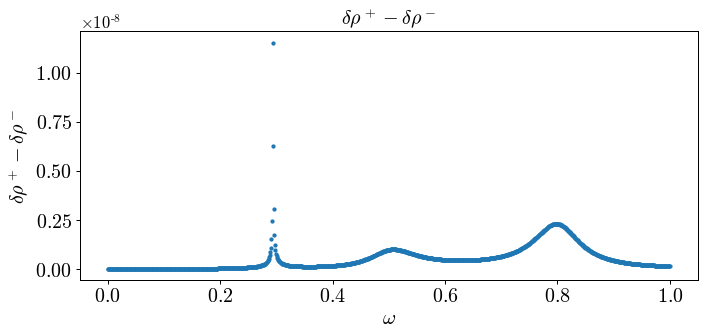

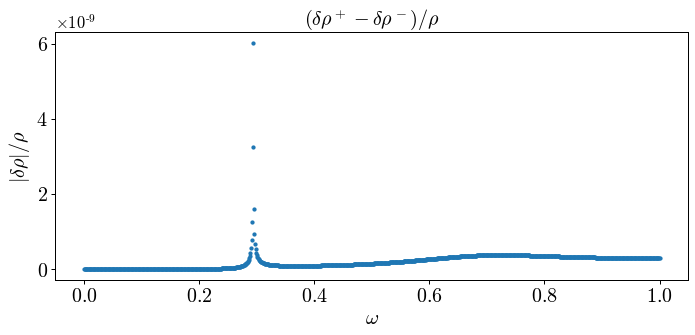

In [35]:
pt.scatter_1d(omega, delta_rho_plus - delta_rho_minus, ax_label = \
              [r'$\omega$', r'$\delta\rho^+ - \delta\rho^-$'], title = r'$\delta\rho^+ - \delta\rho^-$')
pt.scatter_1d(omega, (delta_rho_plus - delta_rho_minus) / np.complex128(rho_center).imag, ax_label = \
              [r'$\omega$', r'$|\delta\rho| / \rho$'], title = r'$(\delta\rho^+ - \delta\rho^-) / \rho$')

### Verify that $|S_N(\zeta)|$ is the largest Nevanlinna coefficient

In [36]:
bad_idxs = np.where(np.abs(cN_float) >= 1)[0]
print('Indices where |c_N|\geq 1: ' + str(bad_idxs))
# These indices correspond to points where $|S_N|^2 - |R_N|^2 has a zero crossing! This combination should always be positive (from the math paper)

Indices where |c_N|\geq 1: []


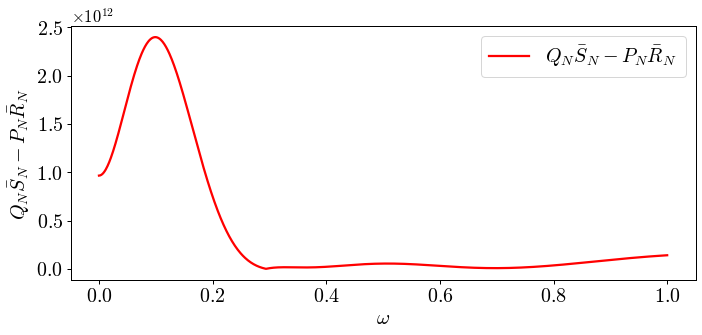

In [37]:
# Look at Q_N(\zeta) \bar{S}_N(\zeta) - P_N(\zeta) \bar{R}_N(\zeta)
fig, axes = pt.add_subplots()
ax1 = axes[0]
num_cN = np.complex128(nev_coeffs_ext['Q'] * mpc_conj(nev_coeffs_ext['S']) - nev_coeffs_ext['P'] * mpc_conj(nev_coeffs_ext['R']))

pt.plot_1d_data(omega, np.abs(num_cN), ax = ax1, fn_label=r'$Q_N \bar{S}_N - P_N \bar{R}_N$', col = 'r')
pt.add_xlabel(ax1, r'$\omega$')
pt.add_ylabel(ax1, r'$Q_N \bar{S}_N - P_N \bar{R}_N$')
ax1.legend(fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/det_identity_ext_prec.pdf', bbox_inches = 'tight')

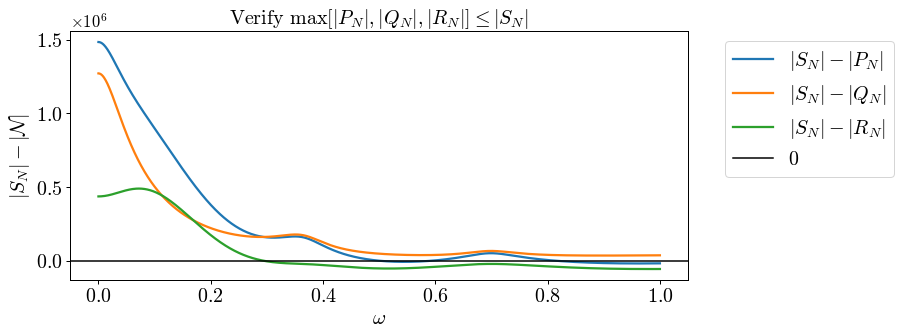

In [38]:
# Verify that |S| \geq |P|, |Q|, |R|
fig, axes = pt.add_subplots()
ax = axes[0]
for ii, key in enumerate(['P','Q','R']):
    pt.plot_1d_data(omega, np.abs(nev_coeffs['S']) - np.abs(nev_coeffs[key]), ax = ax, col = nev_cols[ii],\
                      ax_label = [r'$\omega$', r'$|S_N| - |\mathcal{N}|$'], fn_label = r'$|S_N| - |'+key+'_N|$', \
                      title = r'Verify $\max[|P_N|, |Q_N|, |R_N|] \leq |S_N|$')
pt.add_line(ax, 0, orientation = 'h', c = 'k', label = '0')
lbl = r'$|c_N| > 1$'
for tmp_idx in bad_idxs:
    pt.add_line(ax, omega[tmp_idx], c = 'c', label = lbl)
    lbl = '_nolegend_'
ax.legend(bbox_to_anchor=(1.35, 1), loc='upper right', fontsize = default_style['fontsize'])
# fig.savefig('/Users/theoares/Dropbox (MIT)/research/spectral/figures/writeup/broken_identity_gaussian.pdf', bbox_inches = 'tight')